## Clustering

Sergei R.

## K-Means

K-Means is a classical clustering algrithm. `K` stands for K clusters and `means` means (yes) that the cluster center is a *mean (average) point* of the cluster. The steps are the following:
<ol>
    <li>Randomly initialize K cluster centers.</li>
    <li>Cluster (label) the data according to the current clusters.</li>
    <li>Recalculate cluster centers.</li>
    <li>Do steps 2, 3 until convergence. The algorithm is converged when the cluster centers do not change.</li>
</ol>

### K-Means implementation

In [ ]:
! pip install kneed # IF you don't have it 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics.cluster import contingency_matrix
from sklearn.utils import shuffle
from scipy.spatial.distance import euclidean 
from sklearn.cluster import KMeans
from sklearn import datasets
import pandas as pd 
 
import os.path
from kneed import KneeLocator, DataGenerator

In [2]:
data_path = "data_pd.npy"


In [3]:
# load, transrorm data without labels
def load_data(data_path):
    data = np.load("46.npy")
    X = np.zeros((data.shape[0]*data.shape[1]*data.shape[2],4))

    ij=0
    for i in range (data.shape[0]):
        for j in range (data.shape[1]):
            for k in range (data.shape[2]):
                X[ij,:] = [i,j,k, data[i,j,k]]
                ij +=1

    np.save(data_path,X)
    return X

In [12]:
if os.path.isfile(data_path):
    X = np.load(data_path)
    print ("Converted data loaded")
else:
    X = load_data(data_path)
    print ("Converted data created")

Converted data loaded


In [15]:
X

array([[  0.,   0.,   0.,  32.],
       [  0.,   0.,   1.,  29.],
       [  0.,   0.,   2.,  31.],
       ...,
       [ 34., 102., 177., 104.],
       [ 34., 102., 178., 104.],
       [ 34., 102., 179., 103.]])

In [6]:
def cluster_resp(distances):
    # Larger the distance to cluster `k` - less important the point for the cluster `k`
    # That's why we calculate responsibilities using negative distance.
    # Note that this is very similar to the `softmax` function.
    d_exp = np.exp(-distances)
    return d_exp / np.sum(d_exp, axis=1, keepdims=True)


# Another way of measuring the quality of the clustering results.
# Try to deduce the meaning of this `loss` on your own.
# This measure can be used as a criteria for stopping the algorithm.
def loss(X, M, R, dist_type):
    loss = 0
    for k in range(len(M)):
        d = dist(X, M[k],dist_type)
        loss += np.sum(R[:, k] * d * d)
    
    return loss

In [45]:

def dist(x, y,dist_type):
    if dist_type == "euclidian":
        diff = x - y
        dist = np.sqrt(np.sum(diff * diff, axis=-1))
    
    if dist_type == "manhattan":
        diff = x - y
        dist = np.sum(np.abs(diff), axis=-1)
    
    if dist_type == "chebyshev":
        diff = x - y
        dist = np.max(np.abs(diff), axis=-1)
    
    return dist


def k_means(X, K, max_iter=15, max_attempts=10, dist_type = "euclidian"):
    N, D = X.shape
    # Labels
    L = np.zeros(N)
    # Cluster centers
    M = np.zeros((K, D))
    
    for at in range(max_attempts):
        # Randomly initialize the centers
        for k in range(K):
            M[k] = X[np.random.choice(N)]

        # Start K-Means
        for i in range(max_iter):
            # Cluster the data according to current cluster centers.
            # Calculate distances from each point to each cluster.
            dists = []
            for k in range(K):
                # Distance to cluster k
                dists += [dist(X, M[k], dist_type).reshape(-1, 1)]
            
            dists = np.hstack(dists) # [N, K]
            L = np.argmin(dists, axis=1)
            # Recalculate cluster centers
            for k in range(K):
                M[k] = X[L==k].mean(axis=0)


        if(len(np.unique(L)))== K:       # i added clasterrisation control
                break            
        if i == (max_attempts-1):
            print("max_attempts achived, try take another K")
            print("Current K", len(np.unique(L)))
    
    #plot_colored_points(X, L)
    return M, L

Soft K-Means is a modification of classical K-Means that allows you to estimate the probability of belonging a point to some cluster. It is also called 'fuzzy clustering'. The algorithm is the following:

    Randomly initialize K cluster centers.
    Calculate cluster responsibilities. Cluster responsibilities are the probabilities of belonging points to each cluster. (see `cluster_resp` function)
    Recalculate the cluster centers according to the cluster responsibilities.
    Do steps 2, 3 until convergence. The algorithm is converged when the cluster centers do not change (or change very little).


In [44]:
def soft_k_means(X, K, dist_type = "euclidian", max_iter=15):
    # Функция для расчета нечеткого k-means (с-means)
    N, D = X.shape

    # Responsibility matrix.
    # R[i, j] = probability that point `i` belongs to cluster `j`
    # or responsibility of the cluster `j` for the point `i`.
    R = np.zeros((N, K))
    # Cluster centers
    M = np.zeros((K, D))
    # Loss array
    losses = []

    # Randomly initialize the centers
    for k in range(K):
        M[k] = X[np.random.choice(N)]

    # Start Soft K-Means
    for i in range(max_iter):
        # RECALCULATE RESPONSIBILITIES
        # Calculate distances from each point to each cluster
        dists = []
        for m in range(K):
            dists += [dist(X, M[m], dist_type).reshape(-1, 1)]
        dists = np.hstack(dists)  # [N, K]

        R = cluster_resp(dists)
        # Recalculate cluster centers
        for k in range(K):
            M[k] = R[:, k].dot(X) / R[:, k].sum()

        losses.append(loss(X, M, R,dist_type))

    return M,R , losses

In [9]:
# Internal metric

def metrics_davies_bouldin(X, cluster_labels, distance=euclidean):
    """
    Computes Davies Bouldin Index.
    
    Parameters
    ----------
    X : ndarray
        Data points. Shape [n_points, num_features].
    cluster_labels : ndarray
        Contains clustering labels. Shape [n_points].
    distance : function
        Python function with API: distance(vector_a, vector_b) -> float.
    
    Returns
    -------
    float
        Davies Bouldin Index.
    """
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []
    
    for i in range(n_cluster):
        for j in range(n_cluster):
            if (j != i) and (~np.isnan(centroids[i]).any() and ~np.isnan(centroids[j]).any()): 
                db.append((variances[i] + variances[j]) / distance(centroids[i],centroids[j]))
    #print(len(db))
    return(np.max(db) / n_cluster)

# Compute metrics and find optimum K  with K-means 

In [ ]:
# In case of internal evaluation you can judge the results only by comparison
max_k = 30
start_k = 2 
metric_arr1=np.zeros((max_k,start_k))
metric_arr2=np.zeros((max_k,start_k))
metric_arr3=np.zeros((max_k,start_k))
K_optimums = np.zeros((3))

for i in range(start_k,max_k):
    M, L = k_means(X, K=i, dist_type = "euclidian")
    metric_arr1[i] = i, metrics_davies_bouldin(X, L)  
    #print(f'Converged: {metric_arr1[i]}')
    print("euclidian ok", i)

for i in range(start_k,max_k):
    M, L = k_means(X, K = i, dist_type = "manhattan")
    metric_arr2[i] = i, metrics_davies_bouldin(X, L)  
    #print(f'Converged: {metric_arr1[i]}')
    print("manhattan ok", i)
    
for i in range(start_k,max_k):
    M, L = k_means(X, K=i, dist_type = "chebyshev")
    metric_arr3[i] = i, metrics_davies_bouldin(X, L)  
    #print(f'Converged: {metric_arr1[i]}')
    print("chebyshev ok", i)             

In [63]:
# find optimums
K_optimums[0] = KneeLocator(metric_arr1[start_k:,0], metric_arr1[start_k:,1], curve='convex', direction='decreasing').knee
K_optimums[1] = KneeLocator(metric_arr2[start_k:,0], metric_arr2[start_k:,1], curve='convex', direction='decreasing').knee
K_optimums[2] = KneeLocator(metric_arr3[start_k:,0], metric_arr3[start_k:,1], curve='convex', direction='decreasing').knee

print("******************")
print("OPTIMAL K values:")
print(K_optimums)
K_choised = min(K_optimums)
print("******************")
np.save("result_euclidian_" + str(K_choised) + ".npy",metric_arr1)

******************
OPTIMAL K values:
[10. 13.  9.]
******************


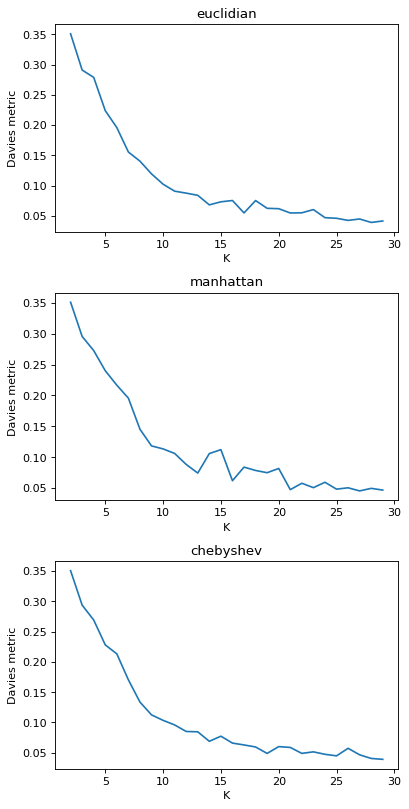

In [61]:
# visualise "euclidian","manhattan","chebyshev" in with K-means cases 

metric_arr_full = np.concatenate((metric_arr1, metric_arr2,metric_arr3), axis=1)
metric_arr_full = metric_arr_full[:,(0,1,3,5)]
titles = ["euclidian","manhattan","chebyshev"]
fig, axs = plt.subplots(3, 1, constrained_layout=True,figsize=(5, 10), dpi=80,)
for j in range(3):
    axs[j].plot(metric_arr_full[start_k :,0], metric_arr_full[start_k :,1+j])
    axs[j].set_title(titles[j])
    axs[j].set_xlabel('K')
    axs[j].set_ylabel('Davies metric')

# Compute metrics and find optimum K  with Soft K-means 

In [ ]:
max_k = 30
start_k = 2 
metric_soft_arr1=np.zeros((max_k,start_k))
metric_soft_arr2=np.zeros((max_k,start_k))
metric_soft_arr3=np.zeros((max_k,start_k))

K_optimums = np.zeros((3))

for i in range(start_k,max_k):
    M, R ,l = soft_k_means(X, K=i, dist_type = "euclidian")
    L_soft = np.argmax(R, axis=1)
    metric_soft_arr1[i] = i, metrics_davies_bouldin(X, L_soft)  
    #print(f'Converged: {metric_arr1[i]}')
    print("euclidian ok", i)

for i in range(start_k,max_k):
    M, R ,l = soft_k_means(X, K = i, dist_type = "manhattan")
    L_soft = np.argmax(R, axis=1)
    metric_soft_arr2[i] = i, metrics_davies_bouldin(X, L_soft)  
    #print(f'Converged: {metric_arr1[i]}')
    print("manhattan ok", i) 

for i in range(start_k,max_k):
    M, R, l = soft_k_means(X, K=i, dist_type = "chebyshev")
    L_soft = np.argmax(R, axis=1)
    metric_soft_arr3[i] = i, metrics_davies_bouldin(X, L_soft)   
    #print(f'Converged: {metric_arr1[i]}')  
    print("chebyshev ok", i)

In [74]:
# find optimums 
K_optimums[0] = KneeLocator(metric_soft_arr1[start_k:,0], metric_soft_arr1[start_k:,1], curve='convex', direction='decreasing').knee
K_optimums[1] = KneeLocator(metric_soft_arr2[start_k:,0], metric_soft_arr2[start_k:,1], curve='convex', direction='decreasing').knee
K_optimums[2] = KneeLocator(metric_soft_arr3[start_k:,0], metric_soft_arr3[start_k:,1], curve='convex', direction='decreasing').knee

print("******************")
print("OPTIMAL K values:")
print("******************")
print(K_optimums)
K_choised = min(K_optimums)
np.save("result_euclidian_" + str(K_choised) + ".npy",metric_soft_arr1)

******************
OPTIMAL K values:
******************
[12. 11. 13.]


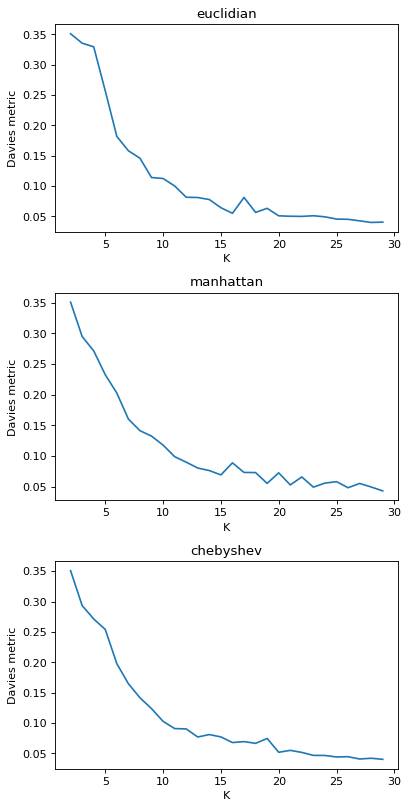

In [71]:
# visualise "euclidian","manhattan","chebyshev" in with soft K-means cases 

metric_arr_soft_full = np.concatenate((metric_soft_arr1, metric_soft_arr2,metric_soft_arr3), axis=1)
metric_arr_soft_full = metric_arr_soft_full[:,(0,1,3,5)]
titles = ["euclidian","manhattan","chebyshev"]
fig, axs = plt.subplots(3, 1, constrained_layout=True,figsize=(5, 10), dpi=80,)
for j in range(3):
    axs[j].plot(metric_arr_soft_full[start_k:,0],metric_arr_soft_full[start_k:,1+j])
    axs[j].set_title(titles[j])
    axs[j].set_xlabel('K')
    axs[j].set_ylabel('Davies metric')

# Conclusion

1)K-Means result is highly dependent on the initial values of the cluster centers, so you can try other ways of initializing.

2) With Knee-point we can find Optimum on metrics that to find number K.
 In current work optimal K starts from **9 to 13** (we calculated metrics with different distance metrics)

3) Soft K-Means can achieve separation in ambiguous data than just K-Means.

4) Very slow computting on CPU

## Task

Use the given data and cluster it using K-Means and its `soft` version, compare results. Find the number of clusters that yields the highest purity, use different distance metrics: euclidean distance, manhattan distance, сhebyshev distance. Plot the graphs of purity and DBI values depending on the `K` for each of the distance metrics.